# Data Preprocessing

This is file for first data analys and visualization

## Table of content

- [Data Preprocessing](#data-preprocessing)
  - [Table of content](#table-of-content)
  - [Loading libs and files](#loading-libs-and-files)
  - [Filtering Saint Petesburg data](#filtering-saintpetesburg-data)
  - [Dropping unused data](#dropping-unused-data)
  - [Extract time features](#extract-time-features)
  - [Correlation](#correlation)
  - [Final result](#final-result)


## Loading libs and files

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime               import date
from matplotlib             import pyplot as plt
from geopy.geocoders        import Nominatim
from prettytable            import PrettyTable
from print_map              import print_marks

train_data = pd.read_csv("Data/train_data.csv")
train_data.rename(columns = {'timestamp':'hour'}, inplace = True)
test_data = pd.read_csv("Data/test.csv")
valid_data = pd.read_csv("Data/valid.csv")

datasets = [train_data, test_data, valid_data]
report = PrettyTable()
report.field_names = ["Dataset", "Shape", "Duplicates", "NaNs"]
table_names = ['Train', 'Test', 'Validation']
for i, data in enumerate(datasets):
    report.add_row([table_names[i], data.shape, data.duplicated().sum(), data.isna().sum().max()])
print(report)

+------------+---------------+------------+------+
|  Dataset   |     Shape     | Duplicates | NaNs |
+------------+---------------+------------+------+
|   Train    | (8526526, 12) |   69750    |  0   |
|    Test    |    (700, 6)   |     0      |  0   |
| Validation |    (709, 6)   |     0      |  0   |
+------------+---------------+------------+------+


## Filtering Saint Petesburg data

In [20]:
nominatim = Nominatim(user_agent="tutorial")
location = nominatim.geocode("Saint Petersburg, Russia").raw

geo_table = PrettyTable()
geo_table.field_names = ['Dataset', 'Shape']
for i, data in enumerate(datasets):
    min_lat, max_lat, min_lon, max_lon = np.array(location["boundingbox"]).astype(float)
    data = data[(data["lon"] <= max_lon) & (data["lon"] >= min_lon)]
    data = data[(data["lat"] <= max_lat) & (data["lat"] >= min_lat)]
    geo_table.add_row([table_names[i], data.shape])
print(geo_table)

+------------+---------------+
|  Dataset   |     Shape     |
+------------+---------------+
|   Train    | (8447276, 12) |
|    Test    |    (700, 6)   |
| Validation |    (686, 6)   |
+------------+---------------+


## Dropping unused data

In [21]:
datasets[0]["sum"] = 1
for i, data in enumerate(datasets):
    data["datetime"] = pd.to_datetime(data["hour"], unit="s")

datasets[0].drop(["likescount", "commentscount", "symbols_cnt",
                "words_cnt", "hashtags_cnt", "mentions_cnt",
                "links_cnt", "emoji_cnt", "hour"], axis=1, inplace=True)
datasets[0] = datasets[0].groupby(by=["datetime", "point", "lon", "lat"], as_index=False).sum()

## Extract time features

In [22]:
point_ids = datasets[0]["point"].unique().tolist()

In [23]:
for i, data in enumerate(datasets):
    data["hour"] = data["datetime"].dt.hour
    data["day"] = data["datetime"].dt.day
    data["month"] = data["datetime"].dt.month
    data["year"] = data["datetime"].dt.year
    data["weekday"] = data["datetime"].dt.weekday
    data["point_id"] = data["point"].apply(lambda row: point_ids.index(row))
    data.drop(["point", "datetime"], axis=1, inplace=True)
    data.to_csv(f"Preprocessed/{table_names[i]}.csv", index=False)

## Correlation

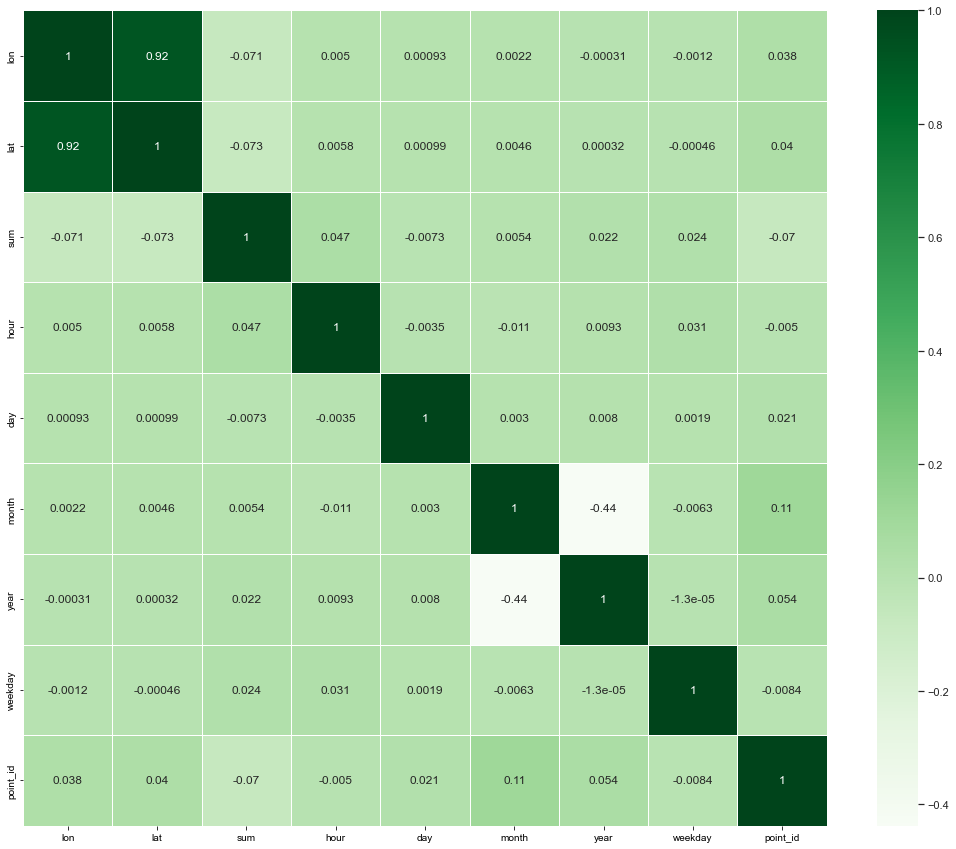

In [24]:
figure, ax = plt.subplots(1, 1, figsize=(18, 15))
sns.set_theme(style="darkgrid", palette="deep")
sns.heatmap(datasets[0].corr(), cmap="Greens", annot=True, linewidths=0.5)
plt.show()

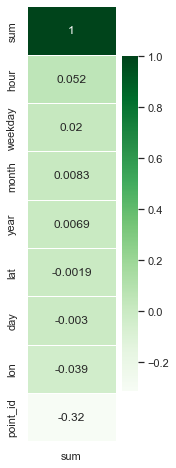

In [25]:
figure, ax = plt.subplots(1, 1, figsize=(2, 8))
sns.heatmap(datasets[0].corr(method="spearman")[["sum"]].sort_values(by="sum", ascending=False), cmap="Greens", annot=True, linewidths=0.5)
plt.show()

## Final result

In [26]:
datasets[0]

,lon,lat,sum,hour,day,month,year,weekday,point_id
0,0.000000,0.000000,3,0,1,1,2019,1,0
1,30.248521,60.018016,1,0,1,1,2019,1,1
2,30.248521,59.850372,1,0,1,1,2019,1,2
3,30.239538,59.965226,1,0,1,1,2019,1,3
4,30.239538,59.858267,2,0,1,1,2019,1,4
...,...,...,...,...,...,...,...,...,...
3635536,30.284454,59.944987,1,23,31,1,2020,4,737
3635537,30.142969,60.030359,1,23,31,1,2020,4,232
3635538,30.275471,59.901092,2,23,31,1,2020,4,234
3635539,30.266488,59.944987,1,23,31,1,2020,4,980


In [27]:
map = print_marks(datasets[1])
map